# Module 4a: Getting Hydrological Data
## Finding and Accessing Open Streamflow Data

**Time required:** 25-30 minutes  
**Prerequisites:** Module 3a (Python basics), Module 3b (AI assistance)  
**What you'll learn:** How to find and download hydrological data programmatically

## The Data Challenge

Ask any hydrologist about their biggest challenge, and you'll often hear: **"Getting the data."**

Before you can analyze discharge patterns, calibrate a model, or validate flood predictions, you need data. And getting that data is often harder than the analysis itself.

### Why Is It So Difficult?

| Challenge | Example |
|-----------|--------|
| **Different formats** | CSV, Excel, XML, proprietary formats, PDF tables |
| **Different sources** | National agencies, research institutions, utilities |
| **Access restrictions** | Some data requires registration, payment, or formal requests |
| **Quality variations** | Gaps, errors, different QA procedures |
| **Different conventions** | Date formats, time zones, units (m³/s vs. L/s vs. cfs) |
| **Documentation gaps** | Missing metadata about station location, catchment area |

### The Good News

The hydrological community has been working to make data more accessible. Several **large-scale, open datasets** now exist that provide:

- Standardized formats
- Consistent quality control
- Rich metadata (catchment attributes)
- Easy programmatic access

In this module, we'll explore these resources and learn how to access them with Python.

## Open Hydrological Data Sources

### Global and Continental Datasets

**[Caravan](https://github.com/kratzert/Caravan)** 🌍  
A global collection of meteorological and hydrological data for large-sample hydrology. Combines data from multiple CAMELS datasets worldwide.
- 6,830+ catchments globally
- Daily streamflow + meteorological forcing
- 65+ catchment attributes
- Citation: Kratzert et al. (2023)

**[GRDC (Global Runoff Data Centre)](https://www.bafg.de/GRDC/)**  
The world's largest archive of river discharge data.
- 10,000+ stations worldwide
- Long historical records (some > 100 years)
- Requires registration for access

**[GloFAS](https://www.globalfloods.eu/)** (Global Flood Awareness System)  
Real-time and historical flood forecasting data from ECMWF/Copernicus.

### The CAMELS Family

CAMELS (**C**atchment **A**ttributes and **ME**teorology for **L**arge-sample **S**tudies) is a family of datasets designed for hydrological research. Each regional dataset follows similar standards:

| Dataset | Region | Catchments | Reference |
|---------|--------|------------|----------|
| **CAMELS** | USA | 671 | Newman et al. (2015) |
| **CAMELS-CL** | Chile | 516 | Alvarez-Garreton et al. (2018) |
| **CAMELS-BR** | Brazil | 897 | Chagas et al. (2020) |
| **CAMELS-GB** | Great Britain | 671 | Coxon et al. (2020) |
| **CAMELS-AUS** | Australia | 222 | Fowler et al. (2021) |
| **CAMELS-CH** | Switzerland | 331 | Höge et al. (2023) |
| **LamaH-CE** | Central Europe | 859 | Klingler et al. (2021) |

> **Why CAMELS matters:**  
> These datasets include not just streamflow, but also catchment characteristics (area, elevation, geology, land use) and meteorological forcing. This makes them ideal for testing models, machine learning, and comparative hydrology.

## Practical: Accessing CAMELS Data with Python

We'll use **PyGeoHydro**, a Python package that provides easy access to various hydrological datasets, including CAMELS-US.

### Step 1: Install PyGeoHydro

In your project folder, add the package:

```bash
uv add pygeohydro
```

This may take a moment as it installs PyGeoHydro and its dependencies.

### Step 2: Explore Available Stations

Run the following code to see what's available in the CAMELS dataset. You can run it directly here in the notebook, or save it as `explore_camels.py` to run from the terminal with `uv run explore_camels.py`.

In [8]:
"""Explore CAMELS dataset stations."""

import pygeohydro as gh

print("Loading CAMELS dataset information...")
print()

# Get CAMELS dataset (returns tuple: attributes DataFrame, streamflow Dataset)
camels_attrs, camels_qobs = gh.get_camels()

# Show available information
print(f"Number of stations: {len(camels_attrs)}")
print()

# Show some columns available
print("Available attributes (first 20):")
for i, col in enumerate(camels_attrs.columns[:20]):
    print(f"  {col}")
print(f"  ... and {len(camels_attrs.columns) - 20} more")
print()

# Show sample of station names
print("Sample stations:")
print(camels_attrs[['gauge_name', 'q_mean']].head(10))

Loading CAMELS dataset information...

Number of stations: 671

Available attributes (first 20):
  huc_02
  gauge_name
  q_mean
  runoff_ratio
  slope_fdc
  baseflow_index
  stream_elas
  q5
  q95
  high_q_freq
  high_q_dur
  low_q_freq
  low_q_dur
  zero_q_freq
  hfd_mean
  soil_depth_pelletier
  soil_depth_statsgo
  soil_porosity
  soil_conductivity
  max_water_content
  ... and 41 more

Sample stations:
                                                 gauge_name    q_mean
gauge_id                                                             
01013500                   Fish River Near Fort Kent, Maine  1.699155
01022500            Narraguagus River At Cherryfield, Maine  2.173062
01030500        Mattawamkeag River Near Mattawamkeag, Maine  1.820108
01031500       Piscataquis River Near Dover-Foxcroft, Maine  2.030242
01047000         Carrabassett River Near North Anson, Maine  2.182870
01052500          Diamond River Near Wentworth Location, NH  2.405105
01054200                      

You should see:
- 671 stations available
- Many catchment attributes (area, precipitation, geology, etc.)
- Station names and basic information

> **First run:** The first time you run this, PyGeoHydro will download the CAMELS dataset (~140 MB). This is cached locally for future use.

### Step 3: Select a Station

Let's find a station with interesting characteristics. The code below filters for medium-sized catchments with reasonable runoff:

In [9]:
"""Select a CAMELS station based on criteria."""

import pygeohydro as gh

# Get CAMELS data
camels_attrs, camels_qobs = gh.get_camels()

print("Finding stations with specific characteristics...")
print()

# Filter for medium-sized catchments with good data
# area_gages2: catchment area in km²
# q_mean: mean daily discharge in mm/day
selected = camels_attrs[
    (camels_attrs['area_gages2'] > 100) &      # At least 100 km²
    (camels_attrs['area_gages2'] < 1000) &     # Not too large
    (camels_attrs['q_mean'] > 1.0)             # Reasonable runoff
].copy()

print(f"Stations matching criteria: {len(selected)}")
print()

# Show top 10 by mean discharge
top_stations = selected.nlargest(10, 'q_mean')
print("Top 10 stations by mean runoff:")
print()

for idx, row in top_stations.iterrows():
    print(f"  Station ID: {idx}")
    print(f"  Name: {row['gauge_name']}")
    print(f"  Area: {row['area_gages2']:.0f} km²")
    print(f"  Mean runoff: {row['q_mean']:.2f} mm/day")
    print()

Finding stations with specific characteristics...

Stations matching criteria: 225

Top 10 stations by mean runoff:

  Station ID: 12041200
  Name: Hoh River At Us Highway 101 Near Forks, WA
  Area: 656 km²
  Mean runoff: 9.59 mm/day

  Station ID: 12056500
  Name: Nf Skokomish R Bl Staircase Rpds Nr Hoodsport, WA
  Area: 147 km²
  Mean runoff: 8.70 mm/day

  Station ID: 12147500
  Name: North Fork Tolt River Near Carnation, WA
  Area: 103 km²
  Mean runoff: 8.30 mm/day

  Station ID: 12043000
  Name: Calawah River Near Forks, WA
  Area: 337 km²
  Mean runoff: 7.82 mm/day

  Station ID: 14400000
  Name: Chetco River Near Brookings, OR
  Area: 703 km²
  Mean runoff: 7.57 mm/day

  Station ID: 12141300
  Name: Middle Fork Snoqualmie River Near Tanner, WA
  Area: 402 km²
  Mean runoff: 7.50 mm/day

  Station ID: 12010000
  Name: Naselle River Near Naselle, WA
  Area: 142 km²
  Mean runoff: 7.20 mm/day

  Station ID: 12167000
  Name: Nf Stillaguamish River Near Arlington, WA
  Area: 684 km

Note down a station ID that looks interesting—we'll download its data next.

### Step 4: Download Streamflow Data

Now let's download actual streamflow data for a selected station. Change `STATION_ID` to the station you chose, or use the default example:

In [10]:
"""Download streamflow data from CAMELS."""

import pygeohydro as gh
import pandas as pd

# Configuration - change this to your chosen station
STATION_ID = "01013500"  # Example: Fish River near Fort Kent, Maine

print(f"Downloading data for station: {STATION_ID}")
print()

# Get CAMELS data (attributes and streamflow)
camels_attrs, camels_qobs = gh.get_camels()

if STATION_ID not in camels_attrs.index:
    print(f"Error: Station {STATION_ID} not found in CAMELS dataset.")
    print("Check the station ID and try again.")
else:
    station_info = camels_attrs.loc[STATION_ID]
    area_km2 = station_info['area_gages2']
    print(f"Station: {station_info['gauge_name']}")
    print(f"Area: {area_km2:.0f} km²")
    print(f"Mean elevation: {station_info['elev_mean']:.0f} m")
    print()
    
    # Extract streamflow for this station from the xarray Dataset
    print("Extracting streamflow data...")
    
    # Get discharge data - raw CAMELS data is in cfs (cubic feet per second)
    Q_cfs = camels_qobs['discharge'].sel(station_id=STATION_ID)
    
    # Convert to pandas Series
    Q_cfs = Q_cfs.to_series()
    
    # Convert cfs to m³/s (1 cfs = 0.0283168 m³/s)
    Q_m3s = Q_cfs * 0.0283168
    
    # Also calculate mm/day for reference
    Q_mm_day = Q_m3s * 86400 / (area_km2 * 1e6) * 1000
    
    print(f"Retrieved {len(Q_m3s)} daily values")
    print(f"Period: {Q_m3s.index.min().strftime('%Y-%m-%d')} to {Q_m3s.index.max().strftime('%Y-%m-%d')}")
    print(f"Missing values: {Q_m3s.isna().sum()}")
    print()
    
    print("Basic statistics (m³/s):")
    print(f"  Mean:   {Q_m3s.mean():.2f}")
    print(f"  Min:    {Q_m3s.min():.2f}")
    print(f"  Max:    {Q_m3s.max():.2f}")
    print()


Station: Fish River Near Fort Kent, Maine
Area: 2253 km²
Mean elevation: 250 m

Extracting streamflow data...
Retrieved 12784 daily values
Period: 1980-01-01 to 2014-12-31
Missing values: 92

Basic statistics (m³/s):
  Mean:   43.76
  Min:    1.19
  Max:    506.87

Station: Fish River Near Fort Kent, Maine
Area: 2253 km²
Mean elevation: 250 m

Extracting streamflow data...
Retrieved 12784 daily values
Period: 1980-01-01 to 2014-12-31
Missing values: 92

Basic statistics (m³/s):
  Mean:   43.76
  Min:    1.19
  Max:    506.87



### 📁 Understanding File Paths

Before we save our data, let's understand how Python finds files on your computer.

#### What is a File Path?

A **path** tells Python where to find (or save) a file. There are two types:

**1. Absolute Path** (Full address from the root of your computer)
```python
# macOS/Linux example:
'/Users/yourname/Documents/GitHub/python-for-water-modellers/data/my_data.csv'

# Windows example:
'C:\\Users\\yourname\\Documents\\GitHub\\python-for-water-modellers\\data\\my_data.csv'
```

**2. Relative Path** (Address relative to your current location)
```python
# Relative to where this notebook is running
'../data/my_data.csv'
```

#### Understanding Relative Paths

Think of your project structure like this:
```
python-for-water-modellers/          ← Project root
├── data/                            ← Data folder
│   └── my_data.csv                  
├── tutorials/                       ← We are HERE (this notebook)
│   ├── 04a_getting_data.ipynb      
│   └── 04b_discharge_analysis.ipynb
```

When this notebook runs, Python's "current location" is the `tutorials/` folder.

**Relative path symbols:**
- `./` = current folder (tutorials/)
- `../` = go up one level (to project root)
- `../data/` = go up one level, then into data/

So `../data/my_data.csv` means:
1. Start in `tutorials/` (where the notebook is)
2. Go up one level with `../` (now in project root)
3. Go into `data/` folder
4. Access `my_data.csv`

#### Why Use Relative Paths?

✅ **Portable**: Works on anyone's computer, regardless of their username or file structure  
✅ **Version control friendly**: Paths work for all team members  
✅ **Organized**: Keeps related files together in your project

❌ **Don't use absolute paths** in shared code - they only work on your specific computer!

#### In Our Code

```python
output_file = f'../data/camels_{STATION_ID}_discharge.csv'
```

This will save the file in the `data/` folder at the project root, making it easy to find and use in Module 4b!

In [11]:
    # Save to CSV for later use
    output_df = pd.DataFrame({
        'date': Q_m3s.index,
        'discharge_m3s': Q_m3s.values,
        'discharge_mm_day': Q_mm_day.values
    })
    output_df['station_id'] = STATION_ID
    output_df['station_name'] = station_info['gauge_name']
    
    # Save using relative path: up one level (../) then into data/ folder
    output_file = f'../data/camels_{STATION_ID}_discharge.csv'
    output_df.to_csv(output_file, index=False)
    print(f"Data saved to: {output_file}")
    print()
    print("You can now use this file in Module 3b for analysis!")

Data saved to: ../data/camels_01013500_discharge.csv

You can now use this file in Module 3b for analysis!


### Step 5: Quick Visualization

Let's make a quick plot to verify the data looks reasonable:

Loading: ../data/camels_01013500_discharge.csv
Saved: ../data/streamflow_preview.png

Open the PNG file to see your hydrograph!


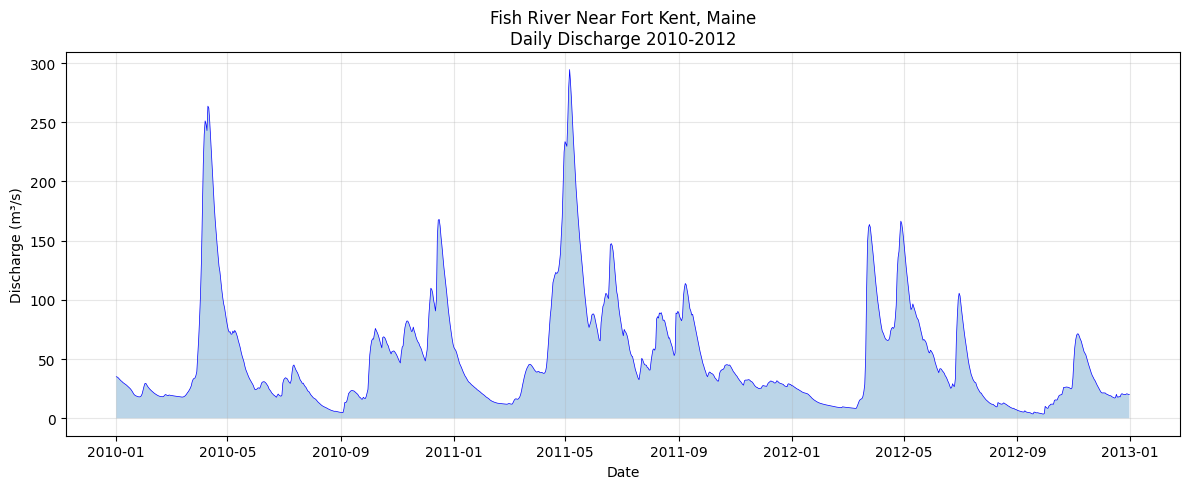

In [12]:
"""Quick visualization of downloaded streamflow data."""

import pandas as pd
import matplotlib.pyplot as plt

# Load the data we just downloaded
# Update filename to match your downloaded data
INPUT_FILE = '../data/camels_01013500_discharge.csv'

print(f"Loading: {INPUT_FILE}")
df = pd.read_csv(INPUT_FILE)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

station_name = df['station_name'].iloc[0]

# Create a simple plot
fig, ax = plt.subplots(figsize=(12, 5))

# Plot 3 years of data for clarity
df_subset = df['2010':'2012']

ax.plot(df_subset.index, df_subset['discharge_m3s'], 'b-', linewidth=0.5)
ax.fill_between(df_subset.index, 0, df_subset['discharge_m3s'], alpha=0.3)

ax.set_xlabel('Date')
ax.set_ylabel('Discharge (m³/s)')
ax.set_title(f'{station_name}\nDaily Discharge 2010-2012')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/streamflow_preview.png', dpi=150)
print("Saved: ../data/streamflow_preview.png")
print()
print("Open the PNG file to see your hydrograph!")

**What you should see:**
- A hydrograph showing the seasonal pattern of streamflow
- Higher flows in spring (snowmelt) for mountain catchments
- Lower flows in late summer/autumn
- Individual flood peaks from storm events

The plot is saved as `streamflow_preview.png` in your `data/` folder.

## For Swiss-Specific Work: CAMELS-CH

If you're working specifically with Swiss catchments, you'll want to use **CAMELS-CH**.

### What's in CAMELS-CH?

- **331 catchments** across Switzerland
- Daily streamflow data (1981-2020)
- 211 catchment attributes (topography, climate, geology, land cover, hydrology)
- Comprehensive metadata

### How to Access

CAMELS-CH is available from Zenodo:

1. Visit: https://doi.org/10.5281/zenodo.8212506
2. Download the dataset files
3. The data comes as CSV files that you can load with pandas

### Example Loading Code

```python
import pandas as pd

# After downloading and extracting CAMELS-CH
# Load catchment attributes
attributes = pd.read_csv('CAMELS_CH_catchment_attributes.csv')

# Load streamflow for a specific station
streamflow = pd.read_csv('CAMELS_CH_streamflow_daily.csv')

# Filter for your station of interest
station_id = '2004'  # Example: Aare at Ringgenberg
my_data = streamflow[streamflow['station_id'] == station_id]
```

### Citation

When using CAMELS-CH in publications, please cite:

> Höge, M., Kauzlaric, M., Siber, R., Schönenberger, U., Horton, P., Schwanbeck, J., Floriancic, M. G., Viviroli, D., Wilhelm, S., Sikorska-Senoner, A. E., Addor, N., Brunner, M., Pool, S., Zappa, M., & Fenicia, F. (2023). CAMELS-CH: Hydro-meteorological time series and landscape attributes for 331 catchments in hydrologic Switzerland. *Earth System Science Data*, 15, 5755–5784.

## Data Quality Considerations

Whenever you work with hydrological data—whether from CAMELS, national databases, or local sources—always check:

### 1. Missing Values

```python
# Count missing values
missing = df['discharge'].isna().sum()
print(f"Missing: {missing} days ({missing/len(df)*100:.1f}%)")

# Where are they?
missing_periods = df[df['discharge'].isna()]
```

### 2. Suspicious Values

```python
# Check for zeros (often indicate sensor issues)
zeros = (df['discharge'] == 0).sum()

# Check for negative values (physically impossible)
negatives = (df['discharge'] < 0).sum()

# Check for extreme spikes (potential errors)
mean_q = df['discharge'].mean()
std_q = df['discharge'].std()
extremes = df[df['discharge'] > mean_q + 5*std_q]
```

### 3. Time Series Continuity

```python
# Check for gaps in the time series
date_diff = df.index.to_series().diff()
gaps = date_diff[date_diff > pd.Timedelta(days=1)]
print(f"Found {len(gaps)} gaps in the time series")
```

### 4. Physical Plausibility

- Is the catchment area correct?
- Do peak flows coincide with precipitation events?
- Is the seasonal pattern reasonable for the climate?

## Summary

In this module, you learned:

✅ Why getting hydrological data is challenging  
✅ Key open data sources (CAMELS family, GRDC, Caravan)  
✅ How to access CAMELS data programmatically with PyGeoHydro  
✅ How to explore, select, and download station data  
✅ How to save data for offline analysis  
✅ Where to find CAMELS-CH for Swiss-specific work  
✅ What to check for data quality  

### Key Takeaways

1. **Open datasets exist** — You don't always need to process raw data from scratch
2. **Python makes access easy** — A few lines of code can replace hours of manual downloads
3. **Always check quality** — Even curated datasets may have issues
4. **Save locally** — Once you have good data, save it for reproducibility

### What You Created

By running the code cells in this notebook, you:
- Explored available CAMELS stations
- Downloaded streamflow data for your chosen station
- Created a CSV file: `camels_XXXXX_discharge.csv` in the `data/` folder
- Generated a preview plot: `streamflow_preview.png`

---

**Next:** Use your downloaded data for a complete analysis → [Module 4b: Your First Water Modelling Script](04b_discharge_analysis.ipynb)